In [2]:
# requirements
'''
pandas==2.3.0
numpy==2.3.1
matplotlib==3.10.3
scipy==1.16.0
casadi==3.7.0
'''
!pip install pandas==2.3.0 numpy==2.3.1 matplotlib==3.10.3 scipy==1.16.0 casadi==3.7.0 &> /dev/null

In [3]:
# convert from continout to discrete values
# A,B,C,D define continous time linear system
# A - state matix - describes how the current state affects the rate of change of the state.
# B - input matrix - how control inputs influence the rate of change of the state
# C - output matrix - Describes how to obtain the system's outputs from its internal state.
# D - feedforward matrix - Describes how external inputs directly affect the system's outputs

import numpy as np
from scipy.signal import cont2discrete

A = np.array([[0,1],[0,0]])
B = np.array([[0],[1]])
C = np.array([[1, 0],[0, 1]])
D = np.array([[0, 0],[0, 0]])
dt = 0.1
A_disc, B_disc, *_ = cont2discrete((A, B, C, D), dt, method="zoh")

In [4]:
print(A_disc)
print(B_disc)

[[1.  0.1]
 [0.  1. ]]
[[0.005]
 [0.1  ]]


In [7]:
# <!-- ![Alt text](Module_3.0/Screenshot 2025-10-17 at 19.17.15.png)
### The general form:
# ![Alt text](Module_3.0/Screenshot 2025-10-17 at 19.19.52.png)
# In the stage cost, x_k * Q * x_k -> I want the state to be near zero or some target
# -> penalizes deviation 
# -> Q set by EI
# -> second term similarly makes sure there is minimal cost effort

# Casadi is your guy to make the MCP process a breeze! -->

In [8]:
from casadi import *

K = 100 # prediction horizon
n = 2 # number of states
m = 1 # number of inputs

x_init = np.array([[0],[0]]) # random initial state

# Linear cost matrices - start off with identity matrices
Q = np.eye(n)
R = np.array([[1]])

Q_k = Q # applied on terminal state penalty

# constraints for all k 
u_max = 1
x1_max = 1
x1_min = -1


In [9]:
opti = Opti()
x_tot = opti.variable(n, K+1) # state over the prediction horizon
u_tot = opti.variable(m, K)   # input over the prediction horizon

In [10]:
def get_x_next_linear(x_current, u_current):
    return A_disc @ x_current + B_disc @ u_current

In [11]:
opti.subject_to(x_tot[:,0] == x_init)

cost = 0
for k in range(K):
    x_tot_next = get_x_next_linear(x_tot[:,k],u_tot[:,k]) # A@x + B@u
    opti.subject_to(x_tot[:,k+1] == x_tot_next) # setting next state constraint
    
    cost += mtimes([x_tot[:,k].T,Q,x_tot[:,k]]) + mtimes([u_tot[:,k].T,R,u_tot[:,k]])
# terminal cost
cost += mtimes([x_tot[:,K].T,Q_k,x_tot[:,K]])
                   

In [12]:
opti.subject_to(opti.bounded(-u_max, u_tot, u_max)) # input constraints
opti.subject_to(opti.bounded(x1_min, x_tot[0,:], x1_max)) # state constraints

The next part solves the MPC problem we defined earlier:
we've defined:
1. The cost function
2. constraints 
3. optimization variables

now we're assigning ipopt solver to solve the MPC problem!

In [13]:
# opts is a dictionary of configuration settings passed to the solver plugin
opts = {'ipopt.print_level':0, 'print_time':0}
opti.solver('ipopt', opts)
solution = opti.solve()
# opti.solve() when called, compiles the symbolic model into a numerical nonlinear program (NLP)
# and uses the IPOPT solver to find the optimal solution.
# ipopt uses (x_tot, u_tot) to minimize the cost function while satisfying all constraints.
# upon convergence or budget exhaustion, it returns the optimal values of the decision variables.
x_opt = solution.value(x_tot) # extract optimal state trajectory
u_opt = solution.value(u_tot) # extract optimal input trajectory


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [20]:
print(x_opt.shape)

(2, 101)


In [18]:
import matplotlib.pyplot as plt
import numpy as np

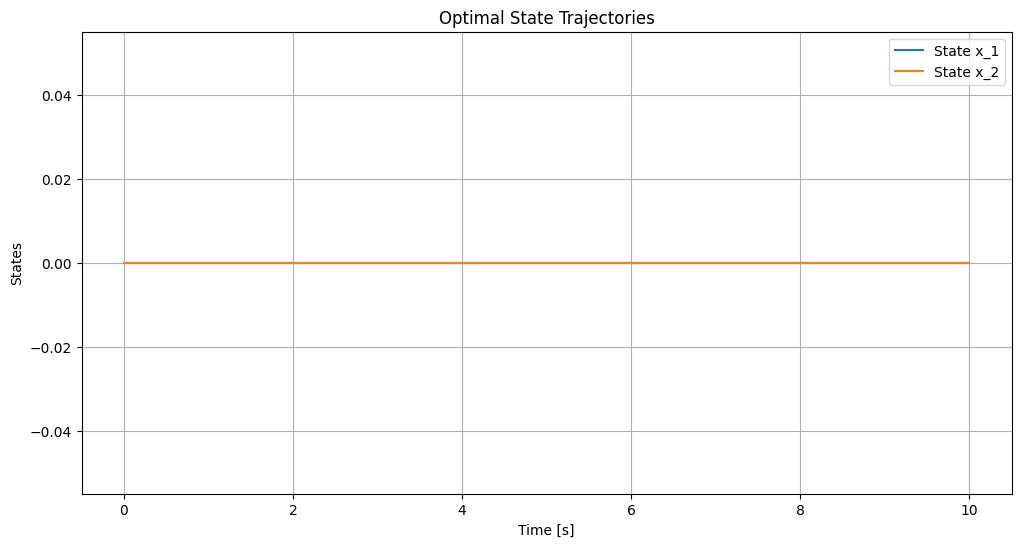

In [22]:
dt = 0.1
k = u_opt.shape[0]
time_x = np.linspace(0, K*dt, K+1)
time_u = np.linspace(0, (K-1)*dt, K)

plt.figure(figsize=(12,6))
for i in range(x_opt.shape[0]):
    plt.plot(time_x,x_opt[i,:], label=f'State x_{i+1}')

plt.xlabel("Time [s]")
plt.ylabel("States")
plt.legend()
plt.title("Optimal State Trajectories")
plt.grid(True)
plt.show()

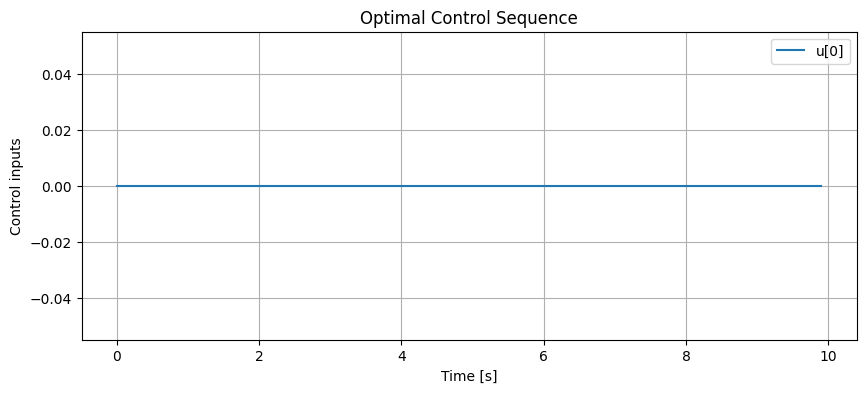

In [24]:
plt.figure(figsize=(10,4))
plt.step(time_u, u_opt, where='post', label="u[0]")
plt.xlabel("Time [s]")
plt.ylabel("Control inputs")
plt.legend()
plt.title("Optimal Control Sequence")
plt.grid(True)
plt.show()

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from casadi import *

def solve_OCP(x_hat, K):
    n = 2 # state dimension
    m = 1 # control dimension

    # Constraints for all k
    u_max = 1
    x_1_max = 1
    x_1_min = -1

    # Linear cost matrices
    Q = np.array([[1. , 0],
                [0. , 1. ]])
    R = np.array([[1]])
    Q_K = Q

    opti = Opti()
    x_tot = opti.variable(n, K+1)  # State trajectory
    u_tot = opti.variable(m, K)    # Control trajectory

    # Specify the initial condition
    opti.subject_to(x_tot[:, 0] == x_hat)

    cost = 0
    for k in range(K):
        # add dynamic constraints
        x_tot_next = get_x_next_linear(x_tot[:, k], u_tot[:, k])
        opti.subject_to(x_tot[:, k+1] == x_tot_next)

        # add to the cost
        cost += mtimes([x_tot[:,k].T, Q, x_tot[:,k]]) + mtimes([u_tot[:,k].T, R, u_tot[:,k]])

    cost += mtimes([x_tot[:,K].T, Q_K, x_tot[:,K]])

    # constrain the control
    opti.subject_to(opti.bounded(-u_max, u_tot, u_max))

    # constrain the position
    opti.subject_to(opti.bounded(x_1_min, x_tot[0,:], x_1_max))

    # Say we want to minimise the cost and specify the solver (ipopt)
    opts = {"ipopt.print_level": 0, "print_time": 0}
    opti.minimize(cost)
    opti.solver("ipopt", opts)
    
    solution = opti.solve()

    # Get solution
    x_opt = solution.value(x_tot)
    u_opt = solution.value(u_tot)

    # plot_solution(x_opt, u_opt.reshape(1,-1))

    return x_opt, u_opt

def get_x_next_linear(x, u):
    # Linear system
    A = np.array([[1. , 0.1],
                [0. , 1. ]])
    B = np.array([[0.005],
                  [0.1  ]])
    
    return mtimes(A, x) + mtimes(B, u)

def plot_constraints(ax, x_1_max, x_1_min, x2_init_min, x2_init_max):
    ax.plot([x_1_min, x_1_min], [x2_init_min, x2_init_max], 'k-')
    ax.plot([x_1_max, x_1_max], [x2_init_min, x2_init_max], 'k-')


def plot_solution_hold_on(ax, x_tot):
    x_1 = x_tot[0]
    x_2 = x_tot[1]

    x_1 = np.append(x_1[0], x_1)
    x_2 = np.append(x_2[0], x_2)

    ax.plot(x_1, x_2, 'b-')
    ax.plot([x_1[0], x_1[-1]], [x_2[0], x_2[-1]], 'k.')
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.grid(True)

def plot_solution(x_tot, u_tot):
    # this takes lists of numpy arrays...
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(3, 1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2])

    # Plot state versus time
    x_1 = x_tot[0]
    x_2 = x_tot[1]

    # Duplicate the initial state so we can have a nice bar plots.
    x_1 = np.append(x_1[0], x_1)
    x_2 = np.append(x_2[0], x_2)
    time = np.arange(x_tot.shape[1] + 1) # because we duplicate the initial state

    ax1.step(time, x_1, 'b-', label='Position')
    ax1.step(time, x_2, 'r-', label='Velocity')
    ax1.set_xlabel('Time step')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylabel('State')
    ax1.legend()
    ax1.grid(True)
    
    # Plot control versus time
    u = u_tot[0]
    time = np.arange(u_tot.shape[1] + 1)
    ax2.step(time, np.append(u[0], u), 'g-', label='Control input')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Control input')
    ax2.legend()
    ax2.grid(True)

    # Plot the state in state space
    ax3.plot(x_1, x_2, 'k-', label='State')
    ax3.set_xlabel('Position')
    ax3.set_ylabel('Velocity')
    ax3.legend()
    ax3.grid(True)
    
    # Plot the initial and final states
    ax3.plot([x_1[0], x_1[-1]], [x_2[0], x_2[-1]], 'k.')

    plt.tight_layout()
    plt.show()

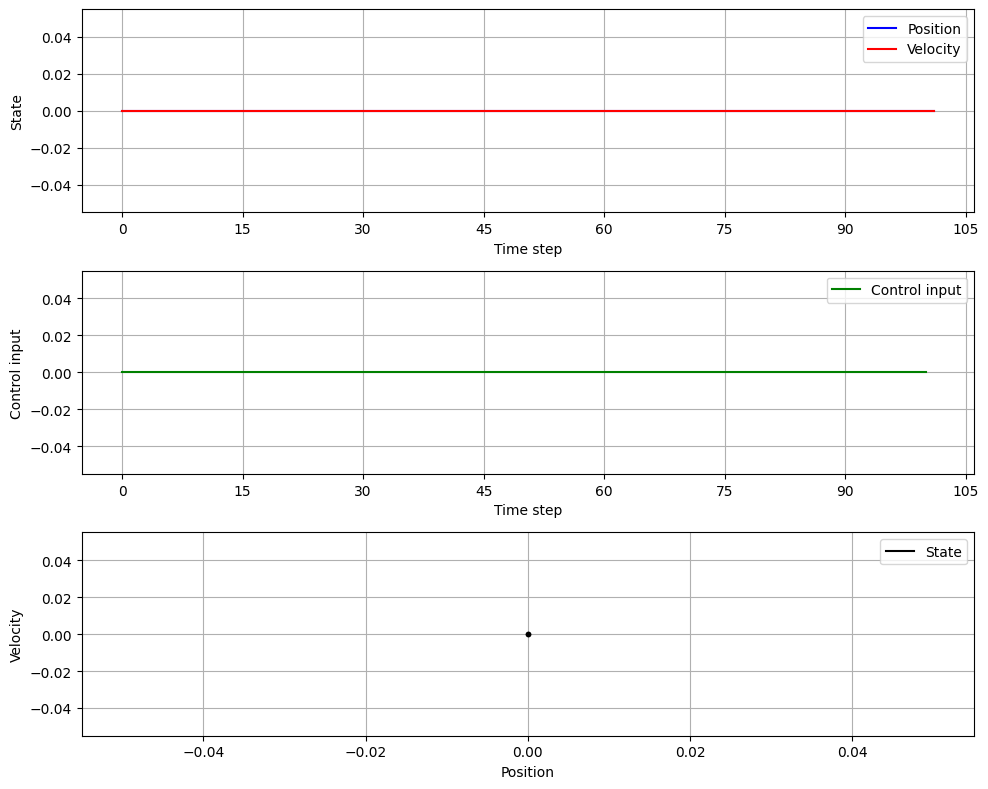

In [27]:
plot_solution(x_opt, u_opt.reshape(1,-1))

In [28]:
# Key points:
# -You do not try random combinations of x_tot, u_tot- instead, the solver uses efficient algorithms (e.g., interior point, SQP)
# to navigate the high dimensional space and converge to the optimal profile.
# -x0 is fixed by measurement and does not change during optimization.
# -The rest of the predicted states and inputs are variables that the solver adjusts to minimize cost under constraints.
# -Every iteration starts fresh from the current actual state, solving for a new optimal control sequence.